# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error as mse

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv')

In [4]:
#convert datetime to epoch/unix time
df['unix'] = pd.to_datetime(df['Datetime']).astype('int64') // 10**9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: **ph** (prediction horizon) is how far ahead in time we predict—the future time offset used when making each prediction. **mu** is the exponential decay factor for sample weights: older observations are downweighted by mu^(steps back), so recent data has more influence than older data.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# ph in seconds (time column is unix/epoch time); 5 minutes = 300 seconds
ph = 5 * 60
# data resolution is 1 sample per minute (60 sec), so 5 minutes = 5 timesteps
ph_index = 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: The first (oldest) data point is 4999 steps back from the last prediction. Its weight is mu^(ns-1) = 0.9^4999, which is vanishingly small (effectively 0). So the first point has almost no influence on the 5000th prediction.

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading datapoints
    # get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys.iloc[0:i]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        # adjust weights: older points get mu^k, then flip so order matches (newest gets 1)
        weights[k] = mu ** k
    weights = np.flip(weights, 0)

    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    # use ph to make the model prediction at time = last time + ph
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

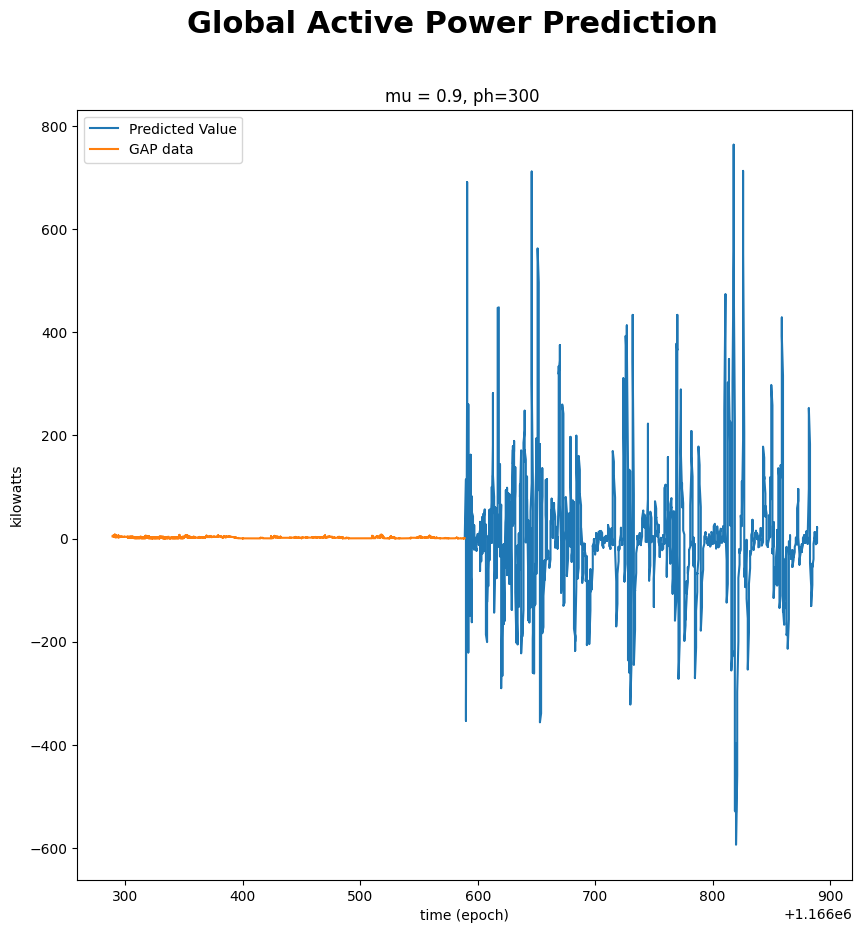

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

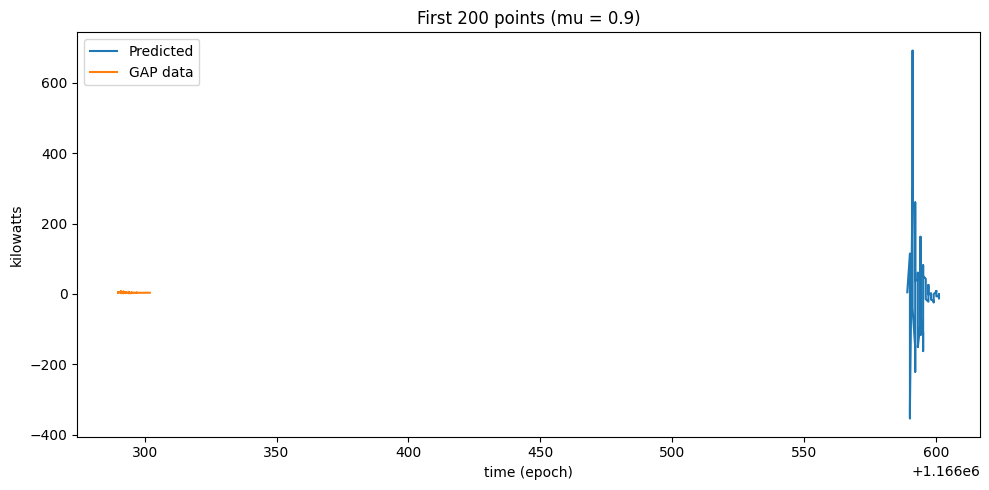

In [8]:
# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('First 200 points (mu = 0.9)')
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted')
ax.plot(ts.iloc[ph_index:ph_index+200, 0], ys.iloc[ph_index:ph_index+200, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

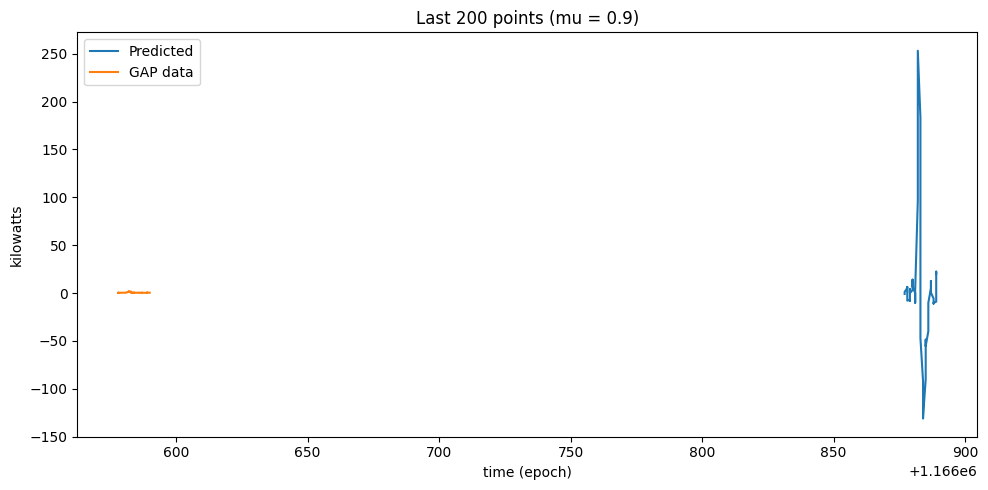

In [9]:
# Plot last 200 data points/predictions (actuals aligned: indices ph_index+(n_s-200-1) to ph_index+n_s-1)
start = ph_index + n_s - 200 - 1
end = ph_index + n_s
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Last 200 points (mu = 0.9)')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted')
ax.plot(ts.iloc[start:end, 0], ys.iloc[start:end, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 16512.78066252699


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model tracks the general level of GAP but often lags or smooths short-term changes. On the charts the predicted line is smoother than the actual GAP, and in both the first and last 200 points it tends to follow the trend rather than short-term swings. The MSE for this model is about 16,513 (kW²). That relatively high MSE indicates that the weighted linear fit with mu = 0.9 is not capturing the variation in GAP very well; predictions are smooth but can miss both level and short-term changes.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [11]:
# Re-run prediction code for mu = 1
mu = 1
for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys.iloc[0:i]
    ns = len(ys_tmp)
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** k
    weights = np.flip(weights, 0)
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp
yp_pred_mu1 = np.copy(yp_pred)

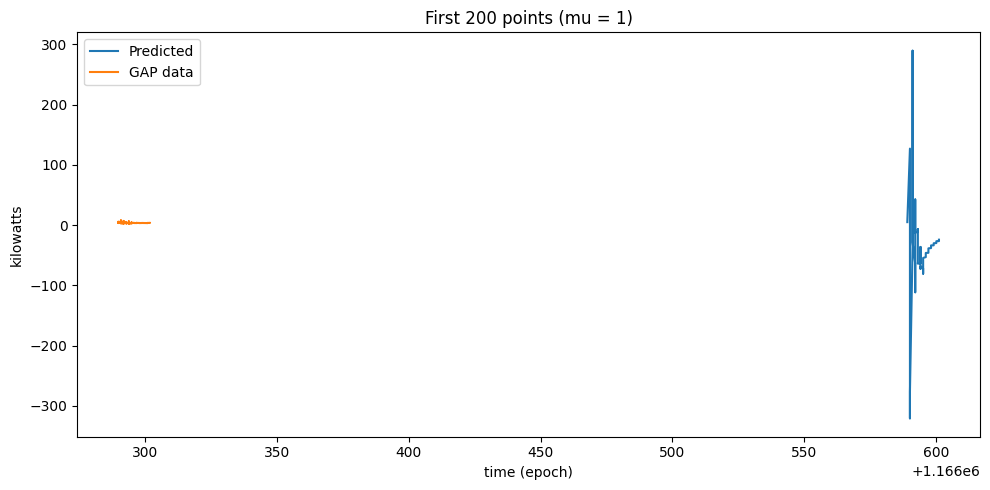

In [12]:
# Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('First 200 points (mu = 1)')
ax.plot(tp_pred[:200], yp_pred_mu1[:200], label='Predicted')
ax.plot(ts.iloc[ph_index:ph_index+200, 0], ys.iloc[ph_index:ph_index+200, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

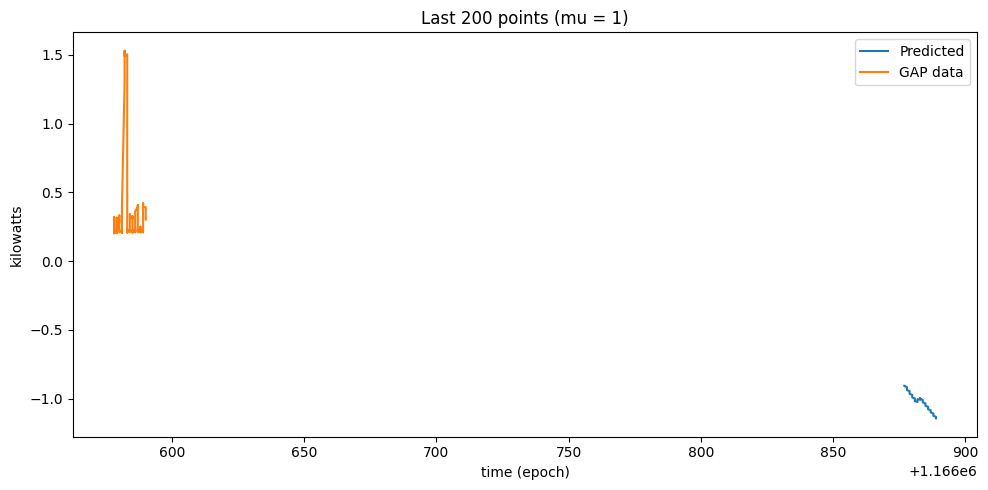

In [13]:
# Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Last 200 points (mu = 1)')
ax.plot(tp_pred[-200:], yp_pred_mu1[-200:], label='Predicted')
ax.plot(ts.iloc[start:end, 0], ys.iloc[start:end, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
# Calculate MSE of predictions for mu = 1
actuals = ys['Global_active_power'].iloc[ph_index:ph_index+n_s-1]
print("MSE (mu = 1):", mse(actuals, yp_pred_mu1))

MSE (mu = 1): 433.26245755555794


In [15]:
# Re-run prediction code for mu = 0.01
mu = 0.01
for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys.iloc[0:i]
    ns = len(ys_tmp)
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** k
    weights = np.flip(weights, 0)
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp
yp_pred_mu001 = np.copy(yp_pred)

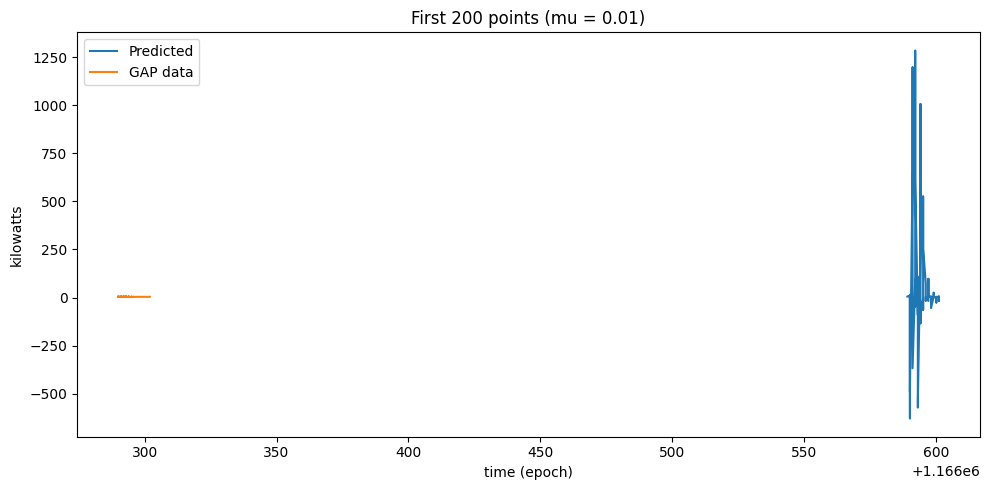

In [16]:
# Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('First 200 points (mu = 0.01)')
ax.plot(tp_pred[:200], yp_pred_mu001[:200], label='Predicted')
ax.plot(ts.iloc[ph_index:ph_index+200, 0], ys.iloc[ph_index:ph_index+200, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

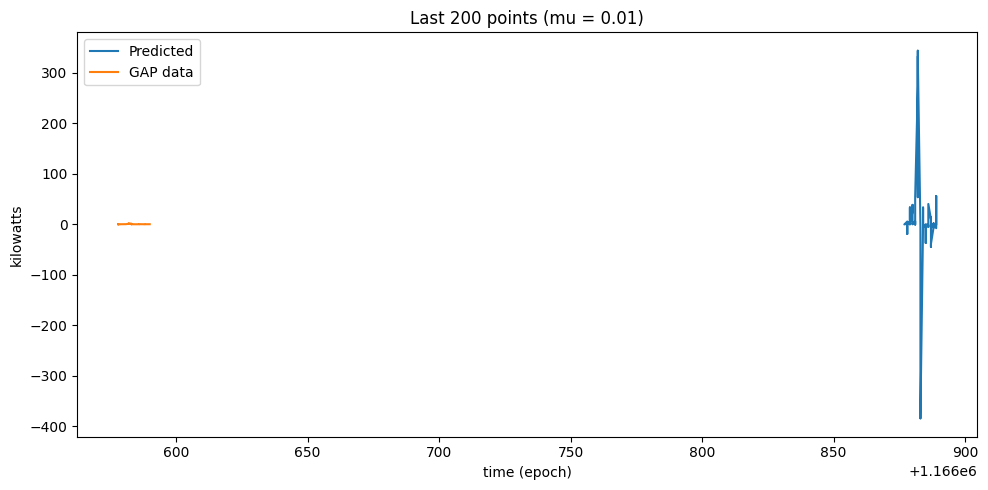

In [17]:
# Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Last 200 points (mu = 0.01)')
ax.plot(tp_pred[-200:], yp_pred_mu001[-200:], label='Predicted')
ax.plot(ts.iloc[start:end, 0], ys.iloc[start:end, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# Calculate MSE of predictions for mu = 0.01
print("MSE (mu = 0.01):", mse(actuals, yp_pred_mu001))
# Restore mu = 0.9 for any subsequent cells that assume base model
mu = 0.9

MSE (mu = 0.01): 54353.77954700764


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With mu = 1, all points get equal weight. The fit is a standard (unweighted) linear regression on all history. On the charts the predicted line follows the long-term trend and is smoother than the actual GAP. For this dataset, the MSE for mu = 1 is about 433—the lowest of the three models. So in our results, equal weighting gave the best predictions, likely because the full history captures the trend well and the time scale (unix time) makes the regression stable.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With mu = 0.01, old points are downweighted very strongly; only the last few observations matter. On the charts the predicted line can track recent swings more closely but is noisier and can overreact. The MSE for mu = 0.01 is about 54,354—the highest of the three. So this model performed worst: with so little effective history the fit is unstable and the predictions are much less accurate.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The best of the three is the one with the lowest MSE. In our results that is mu = 1, with MSE about 433 (compared to about 16,513 for mu = 0.9 and about 54,354 for mu = 0.01). So on this dataset, giving all points equal weight and using the full history produced the most accurate predictions. That makes sense here because the series has a strong trend over time and the regression on unix time benefits from using all the data; downweighting older points (mu = 0.9) or using mostly the last few (mu = 0.01) hurt performance.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: We could: (1) add more predictors (e.g. voltage, time of day, lagged GAP), (2) use a moving window so only the last N points are used, (3) tune ph and mu on a validation set, (4) use time-of-day or seasonality features, or (5) predict a moving average of GAP to smooth the target.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [19]:
# Add voltage to the x-variables in our dataset
ts = pd.DataFrame(df[['unix', 'Voltage']])
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60
ph_index = 5
mu = 0.9

# let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [20]:
# Run the prediction code on the expanded dataset (time + voltage)
for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys.iloc[0:i]
    ns = len(ys_tmp)
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** k
    weights = np.flip(weights, 0)
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    coef = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_[0]
    tp = ts_tmp.iloc[-1, 0] + ph
    # Use last known voltage as proxy for voltage at prediction time
    voltage_at_pred = ts_tmp.iloc[-1, 1]
    yp = coef[0] * tp + coef[1] * voltage_at_pred + q_tmp
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp
yp_pred_voltage = np.copy(yp_pred)

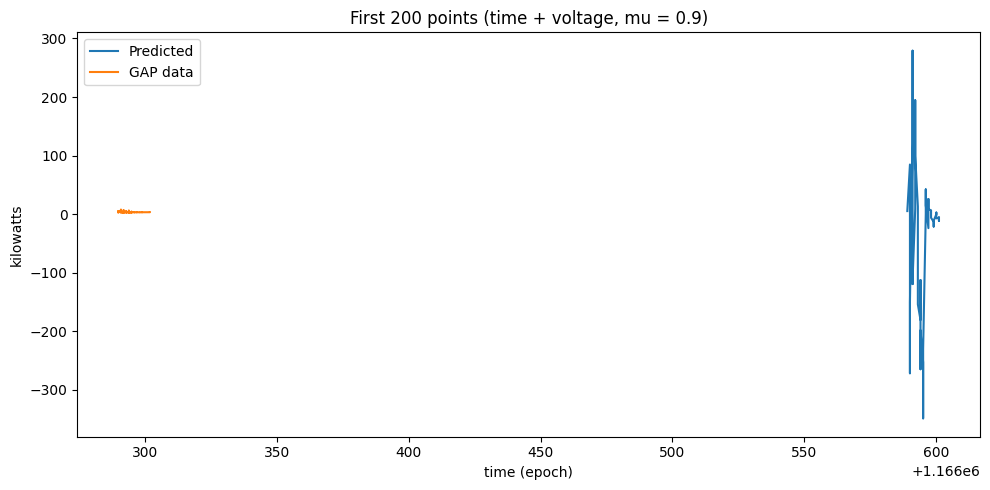

In [21]:
# Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('First 200 points (time + voltage, mu = 0.9)')
ax.plot(tp_pred[:200], yp_pred_voltage[:200], label='Predicted')
ax.plot(ts.iloc[ph_index:ph_index+200, 0], ys.iloc[ph_index:ph_index+200, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

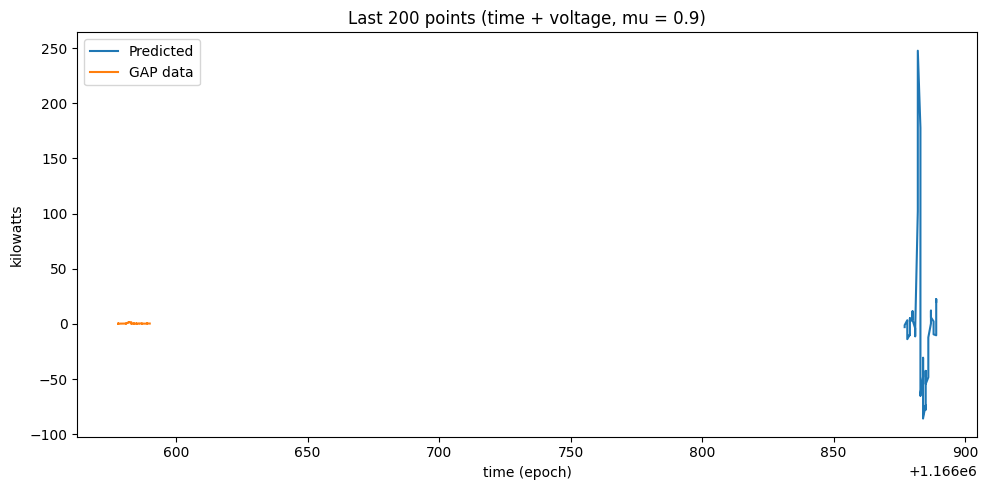

In [22]:
# Plot last 200 data points/predictions for the expanded data
start_v = ph_index + n_s - 200 - 1
end_v = ph_index + n_s
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Last 200 points (time + voltage, mu = 0.9)')
ax.plot(tp_pred[-200:], yp_pred_voltage[-200:], label='Predicted')
ax.plot(ts.iloc[start_v:end_v, 0], ys.iloc[start_v:end_v, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
# Calculate MSE of predictions for the expanded data
actuals_v = ys['Global_active_power'].iloc[ph_index:ph_index+n_s-1]
print("MSE (time + voltage):", mse(actuals_v, yp_pred_voltage))

MSE (time + voltage): 7402.491708645785


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Adding voltage improved the time-only model with mu = 0.9: MSE dropped from about 16,513 to about 7,402. So the model with time and voltage does better than the single-variable (time-only) model with the same mu. It does not beat the best time-only model (mu = 1, MSE about 433), but it shows that voltage carries useful information about GAP—likely because load and voltage are related—and adding it as a second variable helps when using mu = 0.9. 

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Alternative: a moving window that uses only the last 60 observations (1 hour) for each prediction, with mu = 0.9 within the window. This limits the influence of very old data and focuses on recent behavior, which can improve responsiveness and reduce the impact of non-stationarity or regime changes earlier in the series. 

In [24]:
# Alternative model: moving window (last 60 points = 1 hour) with time only
window = 60
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60
ph_index = 5
mu = 0.9
n_s = 5000

tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [25]:
# Re-run the prediction code with moving window (only last `window` points used)
for i in range(2, n_s+1):
    start_idx = max(0, i - window)
    ts_tmp = ts.iloc[start_idx:i]
    ys_tmp = ys.iloc[start_idx:i]
    ns = len(ys_tmp)
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** k
    weights = np.flip(weights, 0)
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]
    tp = ts_tmp.iloc[-1, 0] + ph
    yp = m_tmp * tp + q_tmp
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp
yp_pred_alt = np.copy(yp_pred)

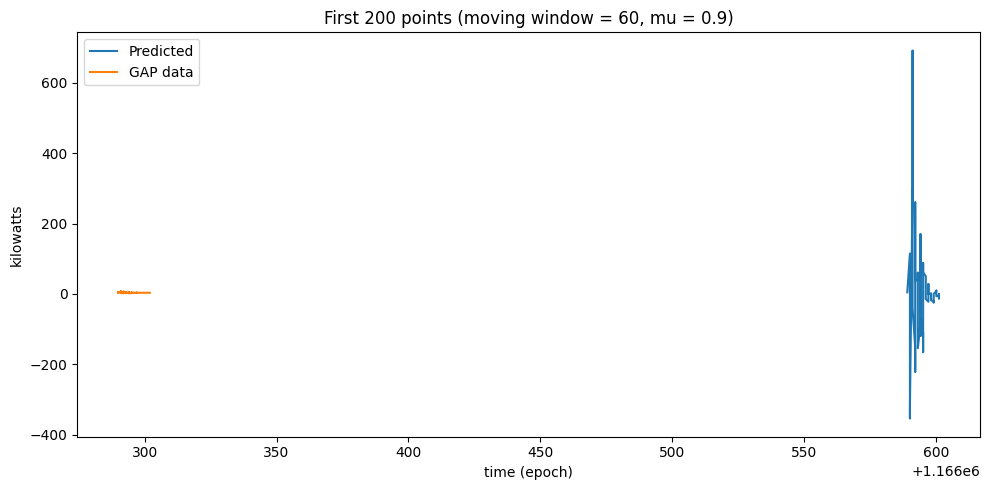

In [26]:
# Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('First 200 points (moving window = 60, mu = 0.9)')
ax.plot(tp_pred[:200], yp_pred_alt[:200], label='Predicted')
ax.plot(ts.iloc[ph_index:ph_index+200, 0], ys.iloc[ph_index:ph_index+200, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

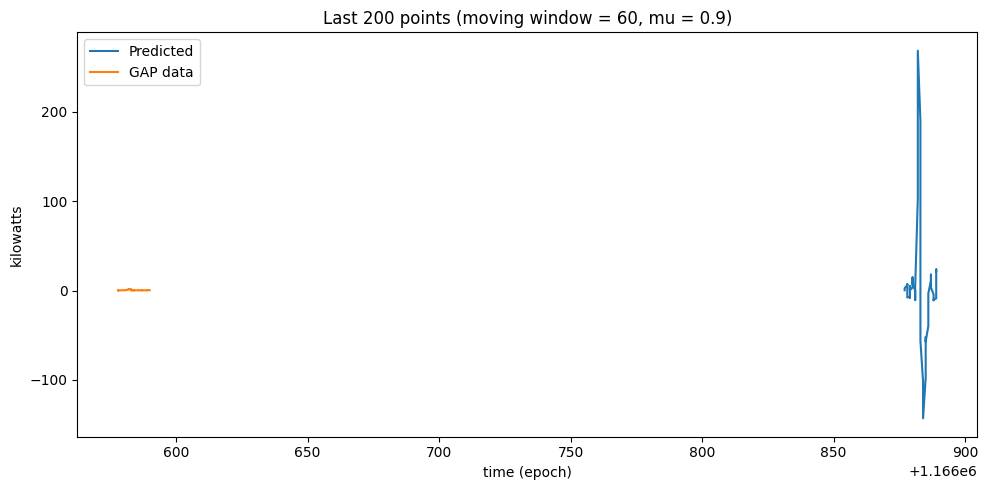

In [27]:
# Plot last 200 data points/predictions for alternative model
start_alt = ph_index + n_s - 200 - 1
end_alt = ph_index + n_s
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Last 200 points (moving window = 60, mu = 0.9)')
ax.plot(tp_pred[-200:], yp_pred_alt[-200:], label='Predicted')
ax.plot(ts.iloc[start_alt:end_alt, 0], ys.iloc[start_alt:end_alt, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

In [28]:
# Calculate MSE of predictions for alternative model
actuals_alt = ys['Global_active_power'].iloc[ph_index:ph_index+n_s-1]
print("MSE (moving window alternative):", mse(actuals_alt, yp_pred_alt))

MSE (moving window alternative): 18019.969193124227


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: In our results the moving-window (60-point) alternative did not improve on the previous models: its MSE is about 18,020, which is worse than the base mu = 0.9 model (about 16,513) and much worse than the best model, mu = 1 (about 433). Limiting to the last hour of data removed useful trend information and made predictions less accurate. To improve further while staying with linear regression we could: add time-of-day (e.g. hour) as a feature, include more predictors (reactive power, sub-metering), try different window sizes or ph, or predict a smoothed target (e.g. 5-minute average GAP) instead of the raw next value.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.